# Distribution fitting with pytorch 

## Overview 

Things to try: 
- Change the loss function: loglikelihood loss instead of MSE 
- Min-max scaling
- Increase model capacity
- LBFGS instead of Adam


## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.random.seed(2023)

n = 50000
shape = 2.5
scale = 1

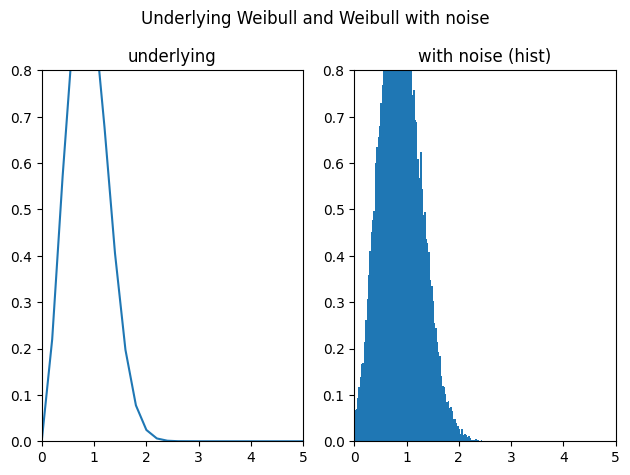

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, .1, n)
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 200, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=100, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 5)
    ax[idx].set_ylim(0, .80)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

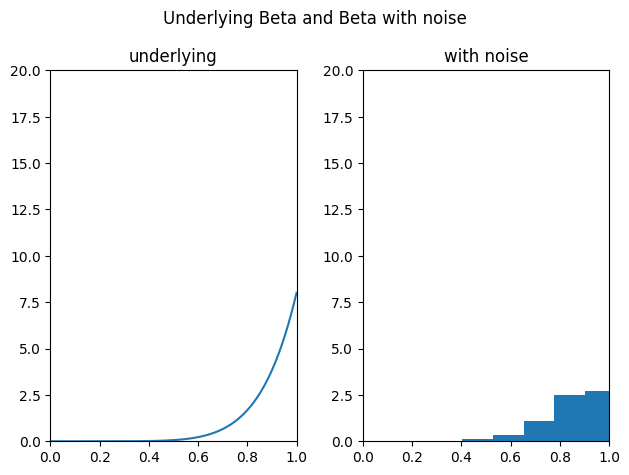

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 1, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 1.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

In [5]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(3, 10).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [6]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        print(f'{lambda_}, {k}, {loss}')
        optimizer.zero_grad()
        losses.append(loss) 
    return losses

In [7]:
def weibull_nll(X, lambda_, k):
    weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
    nll = -torch.log(weibull_pdf).mean()
    return nll

In [8]:
def train_loop_lbfgs(model, optimizer, data_tensor, closure, n=1000): 
    losses = []
    for i in range(n):
        optimizer.step(closure)
        loss = closure()
        losses.append(loss) 
    return losses

In [9]:
def lbfgs_closure():
    # Zero gradients
    preds = m2(x_)
    lambda_, k = m2.weights
    optimizer.zero_grad()
    loss = weibull_nll(weibull_tensor, lambda_, k)
    loss.backward()
    return loss

In [10]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

## Using Adam optimizer on Weibull data 

In [11]:
# min-max scale to speed up convergence. This means we won't get correctly estimated scale param, 
# but shape param will remain same. 
# weibull_data_scaled = [(x - weibull_data.min()) / (weibull_data.max() - weibull_data.min()) for x in weibull_data]
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

4.764761447906494, 9.647486686706543, 15.286598665850267
4.664735794067383, 9.547521591186523, 14.913832425587966
4.564665794372559, 9.447617530822754, 14.541128553851012
4.464532375335693, 9.347800254821777, 14.168441257933623
4.364315986633301, 9.24809741973877, 13.795715209042156
4.263995170593262, 9.148538589477539, 13.422887739085485
4.163548469543457, 9.049154281616211, 13.04988489664615
4.062952995300293, 8.94997787475586, 12.676622011003198
3.962184429168701, 8.851042747497559, 12.303002659120779
3.861217498779297, 8.752385139465332, 11.928912196513018
3.760025978088379, 8.654044151306152, 11.55422161876708
3.6585817337036133, 8.556059837341309, 11.178784684662855
3.5568552017211914, 8.458474159240723, 10.802431120167775
3.45481538772583, 8.361333847045898, 10.424965756165223
3.352429151535034, 8.264687538146973, 10.046169210085285
3.249661445617676, 8.168586730957031, 9.665788693737737
3.146475315093994, 8.073086738586426, 9.283535549540224
3.0428314208984375, 7.97824811935424

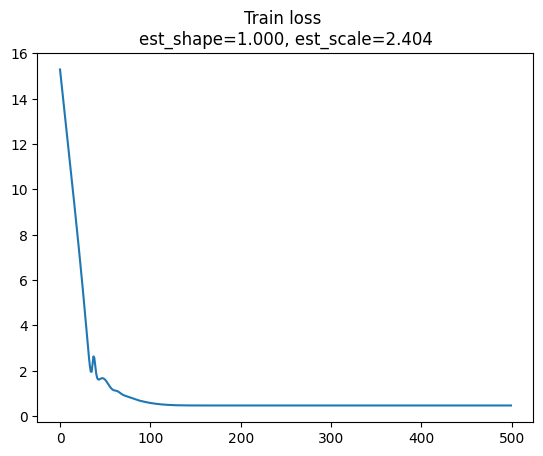

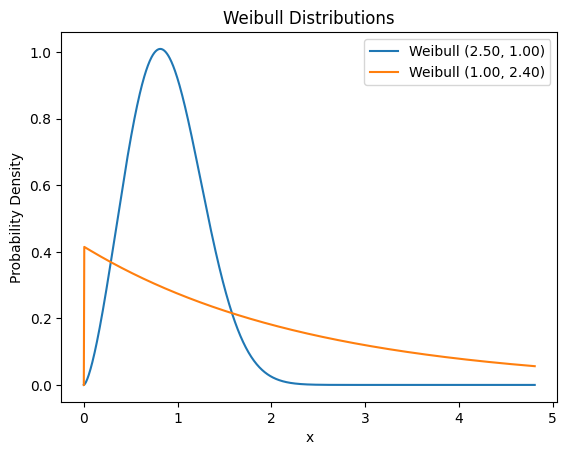

Actual shape=2.5


In [12]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.1)
losses = train_loop(m, opt, data_tensor=weibull_tensor, n=500)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_shape = fitted_params.detach().numpy()[0]
estimated_scale = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

plt.plot(losses)
plt.title(f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}')
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), tuple(fitted_params.detach().numpy().tolist()))
print(f'Actual shape={shape}')

## Using Adam optimizer on Beta data 

## Using LBFGS 

In [13]:
# m2 = Model()
# x_ = Variable(weibull_tensor, requires_grad=True)
# lbfgs = torch.optim.LBFGS(m2.parameters(), history_size=100, max_iter=40)

# train_loop_lbfgs(m2, lbfgs, weibull_tensor, closure=lbfgs_closure, n=10)

In [14]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
num_iterations = 500
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        print(f'{lambda_}, {k}, {loss}')
        loss.backward()
        return loss

    optimizer.step(closure)

# Print the fitted parameters
print("Fitted parameters:", model2.weights)

4.809139728546143, 5.2153000831604, 7.572400933242872
4.769100666046143, 5.155339241027832, 7.432081537690702
3.7271461486816406, 4.191058158874512, 4.869066049771857
1.7192208766937256, 3.119577407836914, 1.2859858710207308
-4.215970039367676, 0.7529920339584351, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan, nan, nan
nan